In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from functools import wraps
import time
import os
import seaborn as sns
from utils import *
from collections import namedtuple

In [29]:
data = load_data()

/home/jovyan/work/utils.py:22: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dataset/data.csv')


Function load_data took 20.1067 seconds


In [30]:
@timeit
def fill_missing_with_0(df):
    # Fill in missing data with 0s. This means if no orders were placed between Ljubljana -> Dunaj at 2019-11-06 09:00:00 and that row is missing form the df dataframe, a new row will be created that contains for that route at the time. 
    # It fills out the info that can be infered from data. No entry for specific pair of cities at specific time means 0 reservations were made
    all_dataframes = [df]
    interval = pd.DateOffset(hours=3)
    date_range = pd.date_range(start=df.AveragePickupRound.min(), end=df.AveragePickupRound.max(), freq=interval)
    for pc in df['pickupCity'].unique():
        for dc in df['dropoffCity'].unique():
            if len(df.query(f'(pickupCity=="{pc}" and dropoffCity=="{dc}")'))>0:
                new_df = pd.DataFrame()
                new_df['AveragePickupRound'] = date_range
                new_df['pickupCity'] = pc
                new_df['dropoffCity'] = dc
                new_df['Count'] = 0
                all_dataframes.append(new_df)
    return pd.concat(all_dataframes).groupby(['pickupCity', 'dropoffCity', 'AveragePickupRound']).max().reset_index().sort_values('AveragePickupRound')

In [31]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    earth_radius = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius * c
    return distance

In [32]:
point_location_1 = get_location_coordinates_and_ranges('ljubljana')
point_location_2 = get_location_coordinates_and_ranges('venice')
print(point_location_1)
print(point_location_2)

Location(latitude=46.056946, longitude=14.505751, location='Ljubljana', radius_in_km=15)
Location(latitude=45.438759, longitude=12.327145, location='Venice', radius_in_km=15)


In [33]:
haversine_distance(point_location_1.latitude, point_location_1.longitude, point_location_2.latitude, point_location_2.longitude)

182.47953934928088

In [34]:
@timeit
def keep_only_only_a_few_pairs_of_cities(df, location1, location2):
    df[f'distance_{location1.location}'] = df.apply(lambda row: haversine_distance(location1.latitude, location1.longitude, row['pickupLatitude'], row['pickupLongitude']), axis=1)
    df[f'distance_{location2.location}'] = df.apply(lambda row: haversine_distance(location2.latitude, location2.longitude, row['dropoffLatitude'], row['dropoffLongitude']), axis=1)
    filtered_df = df[(df[f'distance_{location1.location}'] < location1.radius_in_km) & (df[f'distance_{location2.location}'] < location2.radius_in_km)]

    filtered_df['pickupCity'] = location1.location
    filtered_df['dropoffCity'] = location2.location
    
    #return df.query('pickupCity=="Ljubljana" and dropoffCity=="Benetke"')
    
    return filtered_df

In [35]:
point2point = average_pickup(data)
print(point2point.shape)
point2point = keep_only_only_a_few_pairs_of_cities(point2point, point_location_1, point_location_2)
print(point2point.shape)
point2point = point2point_aggregate(point2point)
point2point = ignore_data_after_2023(point2point)
point2point = fill_missing_with_0(point2point)
point2point

Function average_pickup took 0.0634 seconds
(1420356, 51)


/tmp/ipykernel_1654613/1262067032.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['pickupCity'] = location1.location
/tmp/ipykernel_1654613/1262067032.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dropoffCity'] = location2.location


Function keep_only_only_a_few_pairs_of_cities took 56.5799 seconds
(120896, 53)
Function point2point_aggregate took 15.7351 seconds
Function ignore_data_after_2023 took 0.0054 seconds
Function fill_missing_with_0 took 0.3493 seconds


pickupCity dropoffCity  AveragePickupRound  Count
0      Ljubljana      Venice 2014-04-30 12:00:00      1
1      Ljubljana      Venice 2014-04-30 15:00:00      2
2      Ljubljana      Venice 2014-04-30 18:00:00      0
3      Ljubljana      Venice 2014-04-30 21:00:00      0
4      Ljubljana      Venice 2014-05-01 00:00:00      3
...          ...         ...                 ...    ...
25333  Ljubljana      Venice 2022-12-31 03:00:00      1
25334  Ljubljana      Venice 2022-12-31 06:00:00      3
25335  Ljubljana      Venice 2022-12-31 09:00:00      2
25336  Ljubljana      Venice 2022-12-31 12:00:00      5
25337  Ljubljana      Venice 2022-12-31 15:00:00      1

[25338 rows x 4 columns]

In [36]:
#point2point.head(5).T

In [37]:
# Generate covariates
point2point['DayOfWeek'] = point2point['AveragePickupRound'].dt.dayofweek.values
point2point['MinuteOfDay'] = point2point['AveragePickupRound'].dt.hour * 60 + point2point['AveragePickupRound'].dt.minute
point2point['MonthOfYear'] = point2point['AveragePickupRound'].dt.month
point2point['IsWeekend'] = point2point['AveragePickupRound'].dt.dayofweek.isin([5, 6]).astype(int)

In [38]:
from darts import TimeSeries
# Forecasted timeseries
ts = TimeSeries.from_dataframe(point2point, 'AveragePickupRound', 'Count')

In [39]:
# Covariates
fcov1 = TimeSeries.from_dataframe(point2point, 'AveragePickupRound', 'DayOfWeek')
fcov2 = TimeSeries.from_dataframe(point2point, 'AveragePickupRound', 'MinuteOfDay')
fcov3 = TimeSeries.from_dataframe(point2point, 'AveragePickupRound', 'MonthOfYear')
fcov4 = TimeSeries.from_dataframe(point2point, 'AveragePickupRound', 'IsWeekend')
fcov = fcov1.concatenate(fcov2, axis='component').concatenate(fcov3, axis='component').concatenate(fcov4, axis='component')

from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler
scaler = MinMaxScaler()
transformer = Scaler(scaler)
fcov = transformer.fit_transform(fcov)

In [40]:
# Construct train and test set. Randomly hardcoded int
split_index = 9600
train, test = ts[:split_index], ts[split_index:]

In [41]:
# Plot just a random subset for visualization
#ts[8500:8600].plot(label='subset')
#fcov[8500:8600].plot(label='covariate-dayofweek')

In [42]:
# Construct train and test set. Randomly hardcoded int
#train, test = ts[:8600], ts[8600:]

In [43]:
train.plot()

<Axes: xlabel='AveragePickupRound'>

<Axes: xlabel='AveragePickupRound'>

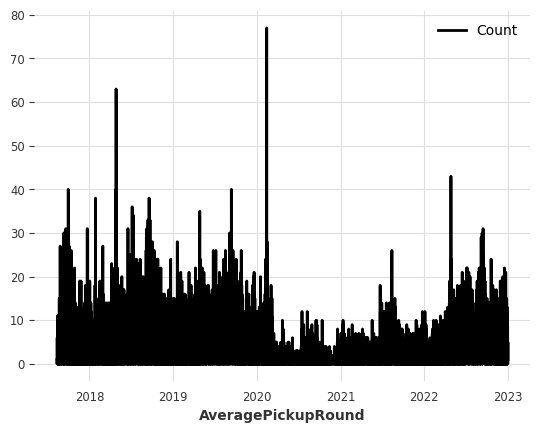

In [44]:
test.plot()

In [45]:
# Train a model
from darts.models import RandomForest
horizon = 8*150 # How many timestemps into the future to predict
lags = 250 # How much history to observe when predicting
#lags = list(range(-1, -100, -1)) + list(range(-100, -600, -5))
print(lags)
covariates_range = 100
model = RandomForest(
    lags=lags,
    lags_future_covariates = list(range(-covariates_range, covariates_range, 5)),
    output_chunk_length=horizon, n_jobs=-1, verbose=False
)
model.fit(train, future_covariates=fcov)

250


RandomForest(lags=250, lags_past_covariates=None, lags_future_covariates=[-100, -95, -90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95], output_chunk_length=1200, add_encoders=None, n_estimators=100, max_depth=None, multi_models=True, use_static_covariates=True, n_jobs=-1, verbose=False)

In [46]:
train

<TimeSeries (DataArray) (AveragePickupRound: 9600, component: 1, sample: 1)>
array([[[ 1.]],

       [[ 2.]],

       [[ 0.]],

       ...,

       [[ 4.]],

       [[ 7.]],

       [[11.]]])
Coordinates:
  * AveragePickupRound  (AveragePickupRound) datetime64[ns] 2014-04-30T12:00:...
  * component           (component) object 'Count'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='AveragePickupRound'>

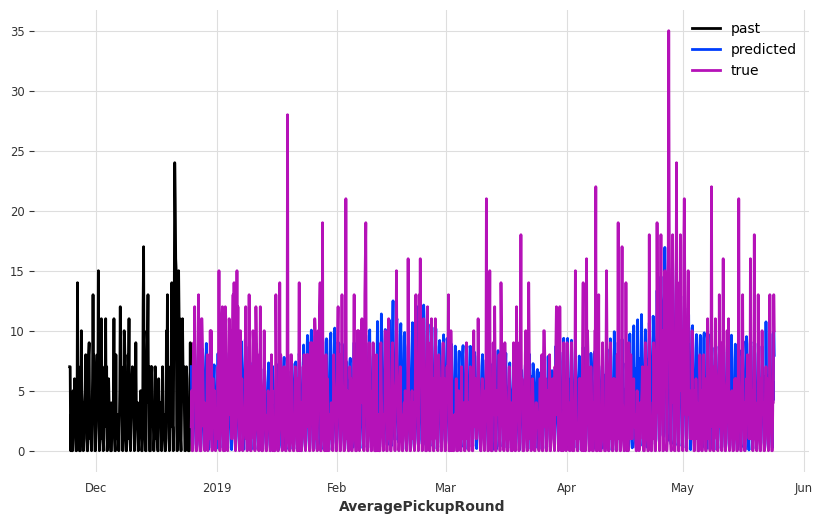

In [47]:
plt.subplots(figsize=(10, 6))
# Take a random seriees from test set. Replace it with any index you want. 
index = 4000
series = test[(index-lags):index]
series.plot(label='past')
pred = model.predict(series=series, n=horizon, future_covariates=fcov)
pred.plot(label='predicted')
true = test[index:(index+horizon)]
true.plot(label='true')

In [48]:
from darts.metrics.metrics import mae

error = mae(pred, true)
print("Error in this case is:", error)

Error in this case is: 2.3737416666666666


In [49]:
from tqdm import tqdm

errors = []
times = []
predictions = []
truths = []
for i in tqdm(range(0, len(test)-covariates_range, 10)):
    ts = test[:(lags+i)]
    pred = model.predict(series=ts, n=horizon, future_covariates=fcov)
    cmp = test.slice(pred.start_time(), pred.end_time())
    if len(pred) != len(cmp):
        break
    error = mae(cmp, pred)
    #print(i, error)
    errors.append(error)
    times.append(ts.end_time())
    predictions.append(pred.all_values().flatten())
    truths.append(cmp.all_values().flatten())    

 91%|█████████▏| 1429/1564 [01:26<00:08, 16.57it/s]


In [50]:
# Plot error for different horizons
plt.plot(times, errors)
plt.xlabel('Time')
plt.ylabel('MAE')
plt.show()

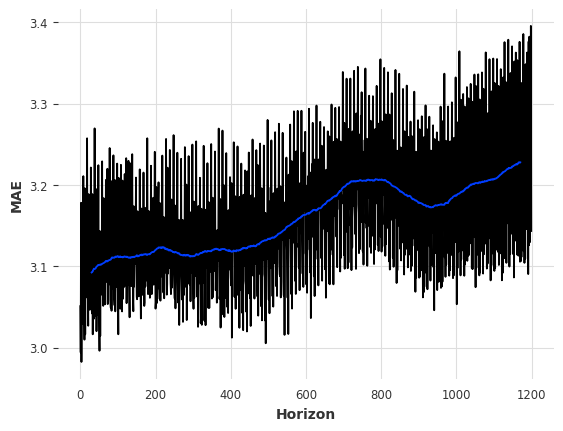

In [51]:
mae = np.mean(np.abs(np.array(predictions)-np.array(truths)), axis=0)
plt.plot(mae)
plt.xlabel('Horizon')
plt.ylabel('MAE')

window_size = 60
kernel = np.ones(window_size) / window_size
moving_average = np.convolve(mae, kernel, mode='valid')
plt.plot(np.array(range(len(moving_average)))+0.5*window_size, moving_average)

plt.show()

In [52]:
mae

array([3.05086774, 2.9939888 , 3.17792862, ..., 3.16668999, 3.39540938,
       3.14324703])

(array([1.30000e+01, 7.40000e+01, 3.20000e+01, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+00, 4.00000e+00, 1.50000e+01, 3.10000e+01, 2.40000e+01,
        3.10000e+01, 1.10000e+01, 2.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 5.90000e+01, 1.12000e+02,
        9.40000e+01, 5.50000e+01, 2.60000e+01, 8.00000e+00, 1.20000e+01,
        2.90000e+01, 4.60000e+01, 3.40000e+01, 3.90000e+01, 7.20000e+01,
        1.96000e+02, 2.14000e+02, 1.59000e+02, 1.94000e+02, 2.54000e+02,
        3.20000e+02, 2.36000e+02, 2.62000e+02, 3.21000e+02, 3.76000e+02,
        4.97000e+02, 7.23000e+02, 1.04100e+03, 1.47200e+03, 1.96700e+03,
        2.97800e+03, 3.59700e+03, 4.29700e+03, 4.77

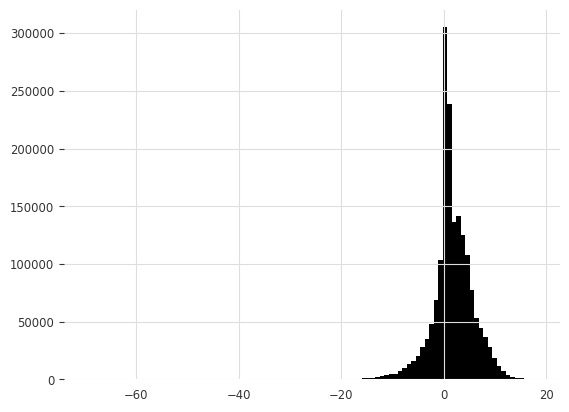

In [53]:
plt.hist((np.array(predictions)-np.array(truths)).flatten(), 100)